In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import sklearn.linear_model
import sklearn.neighbors

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')

import warnings
warnings.filterwarnings("ignore")

import sklearn
from collections import Counter 
import imblearn
import mrmr

In [2]:
data_full = pd.read_csv('full_data_short.csv')

In [3]:
def handle_scale_and_nan(frame,nandecision='drop',scale='MinMax'):
    features = list(frame.select_dtypes(include='float64'))
    cat = list(frame.select_dtypes(include='object'))

    if scale == 'MinMax':
        scaler = sklearn.preprocessing.MinMaxScaler().fit(frame[features])
    elif scale == 'Standard':
        scaler = sklearn.preprocessing.StandardScaler().fit(frame[features])
        
    df_cont = pd.DataFrame(data=scaler.transform(frame[features]), columns=features)
    df_cat = pd.DataFrame(data=frame[cat], columns=cat)
    
    frame = pd.concat([df_cat,df_cont],axis=1)
    
    if nandecision == 'mean':
            for feature in features:
                frame[feature].fillna((frame[feature].mean()), inplace=True)
    elif nandecision == 'drop':
            frame = frame.dropna(axis=1)
        
    return frame

In [4]:
data_full = handle_scale_and_nan(data_full,nandecision='drop',scale='MinMax')

In [60]:
def split_cats_by_tolerance(frame,tolerance,
                       dev_test_split=0.15,train_val_split=0.15,
                       randstate=7975,step=1,
                       categories=['Healthy','AD_MCI','PD','PD_MCI_LBD'], retdev=False):
    """
    Split a chosen pandas dataframe into train, val, and test.
    df_full: the full dataframe
    tolerance: target standard deviation between category abundances in train, val, test frames.
                EG if category "a" has abundances of [0.554, 0.555, 0.571] in the train, val, and test frames, 
                    the std for "a" is 0.00779. 
                    If the stated tolerance is greater than 0.00779, category a is satisfied. 
                    All categories must be satisfied simultaneously by a single random state to break the loop.
    dev_test_split: first split between dev and test frames
    train_val_split: second split between train and val frames
    initial_random_state: start random state search here
    step: step of random state each loop
    categories: categories present in data
    retdev: if False (default), return = df_train, df_val, df_test
            if True, return = df_train, df_val, df_test, df_dev
    """
    
    import sklearn.model_selection
    import pandas as pd
    tolerable_list = []
    while sum(tolerable_list) != 4:
        df_dev, df_test = sklearn.model_selection.train_test_split(frame,test_size=dev_test_split,random_state=randstate)
        df_train, df_val = sklearn.model_selection.train_test_split(df_dev,test_size=train_val_split,random_state=randstate)
        
        train_dict = dict(df_train['group'].value_counts())
        val_dict = dict(df_val['group'].value_counts())
        test_dict = dict(df_test['group'].value_counts())

        tolerable_list = []
        stats_dict = {}
        for i in range(0,len(categories)):
            #try:
            #    train_dict[categories[i]]
            #    val_dict[categories[i]]
            #    test_dict[categories[i]]
            #except KeyError:
            #    break
            percents = [
                (train_dict[categories[i]]/len(df_train)),
                #(val_dict[categories[i]]/len(df_val)),
                (test_dict[categories[i]]/len(df_test)),
                    ]
            standdev = np.std(percents)
            if standdev <= tolerance:
                tolerable_list.append(1)
                stats_dict[str(categories[i])] = [[*percents],standdev]
            else:
                tolerable_list.append(0) 
        randstate += step
    
#    if sum(tolerable_list) == 4:
#        print('Random state meeting tolerance threshold:',randstate-1)
#        print('Value counts in this state')
#        print(train_dict)
#        print(val_dict)
#        print(test_dict)
#        print()
        for i in range(0,len(categories)):
            print('\nPercent',categories[i],'in train, val, test:',stats_dict[categories[i]][0],
                  '\nStandard deviation of these values:',stats_dict[categories[i]][1],'\n')
    
    if retdev == False:
        return df_train, df_val, df_test, randstate-1
    if retdev == True:
        return df_train, df_val, df_test, df_dev, randstate-1


In [6]:
data_train, data_val, data_test, data_dev, randstate = split_cats_by_tolerance(data_full,tolerance=0.0096, randstate=98281,retdev=True)
data_dev = data_dev.drop(columns='assay_ID')
data_train = data_train.drop(columns='assay_ID')
data_val = data_val.drop(columns='assay_ID')
data_test = data_test.drop(columns='assay_ID')


Random state meeting tolerance threshold: 98281
Value counts in this state
{'Healthy': 112, 'AD_MCI': 36, 'PD': 27, 'PD_MCI_LBD': 27}
{'Healthy': 20, 'AD_MCI': 7, 'PD_MCI_LBD': 5, 'PD': 4}
{'Healthy': 24, 'AD_MCI': 8, 'PD_MCI_LBD': 5, 'PD': 5}


Percent Healthy in train, val, test: [0.5544554455445545, 0.5714285714285714] 
Standard deviation of these values: 0.008486562942008447 


Percent AD_MCI in train, val, test: [0.1782178217821782, 0.19047619047619047] 
Standard deviation of these values: 0.006129184347006128 


Percent PD in train, val, test: [0.13366336633663367, 0.11904761904761904] 
Standard deviation of these values: 0.007307873644507315 


Percent PD_MCI_LBD in train, val, test: [0.13366336633663367, 0.11904761904761904] 
Standard deviation of these values: 0.007307873644507315 



Drop healthy from training data, then oversample PD & PD_MCI to 36 counts

In [7]:
def over_under_around_excess(df_train,df_val,cat_in_excess='Healthy',target='group', 
                             randomstate=None,
                             randomstate_sampler=None,model=sklearn.linear_model.RidgeClassifier()):
    """
    Takes dataframe(s) with only the target value and float64 features
    This function is to balance the samples in an imbalanced training dataset that has one category in excess, with additional categories more near each other
    The categories below the category in excess will be oversampled to equality, then the category in excess will be undersampled to equality
    ---Parameters---
    df_train: the training dataframe
    df_val: the validation dataframe
    cat_in_excess: the category which is present in excess, far above the other categories
    target: target column in the dataframe
    randomstate: if chosen, this will the random state for the sampling. Default: None, numpy random integer method between 0 and 4294967295, the range of the sampling module used
    randomstate_sampler: the number of loops to run to compare random states starting from 
    """
    try:
        df_val.columns
    except:
        raise TypeError('Select a validation set in a pandas dataframe to sample against')
    try:
        df_train.columns
    except:
        raise TypeError('Select a training set in a pandas dataframe to sample against')

    X_val = df_val.drop(columns=target)
    y_val = df_val[target]
    stats = []
    if randomstate_sampler == None:
        randomstate_sampler = 1
        loopi = 0
    elif type(randomstate_sampler) == int:
        loopi = 1
        assert randomstate_sampler > 1, TypeError('Select a loop target for random state sampling greater than or equal to 2')
    
    if randomstate == None:
        rndsts = False
    elif type(randomstate) == int:
        rndsts = True
    
    while loopi != randomstate_sampler+1:
        if rndsts == False:
            randomstate = np.random.randint(0,4294967295)
        elif rndsts == True:
            pass
        
        # Drop the excessive category and oversample minority to the intermediate category
        df_train_no_excess = df_train[df_train.group != cat_in_excess]
        over_sampler = imblearn.over_sampling.RandomOverSampler(random_state=randomstate)
        X_train = df_train_no_excess.drop(columns=target)
        y_train = df_train_no_excess[target]
        X_train_over, y_train_over = over_sampler.fit_resample(X_train,y_train)
        df_train_over = pd.concat([y_train_over,X_train_over],axis=1)
        
        # Re-introduce the excessive category and undersample the majority to the minority
        df_train_excess = pd.concat([df_train_over,df_train[df_train[target] == cat_in_excess]])
        under_sampler = imblearn.under_sampling.RandomUnderSampler(random_state=randomstate)
        X_train = df_train_excess.drop(columns=target)
        y_train = df_train_excess[target]
        X_train_under, y_train_under = under_sampler.fit_resample(X_train,y_train)
        df_train_eq = pd.concat([y_train_under,X_train_under],axis=1)
        
        # fit the ridge classifier to the new dataset and provide the balanced accuracy score

        #model.fit(X_train_under,y_train_under)
        #balanced_accuracy_score = sklearn.metrics.balanced_accuracy_score(y_val,model.predict(X_val))
        #if randomstate_sampler == 1:
        #    stats.append([randomstate,balanced_accuracy_score])
        #elif randomstate_sampler > 1:
        #    stats.append([randomstate,balanced_accuracy_score])
        
        loopi += 1
        
        
        
    if randomstate_sampler == 1:
        #print('Ridge classifier score:',stats[0][1])
        return df_train_eq, stats
    elif randomstate_sampler > 1:
        RS, score = zip(*stats)
        sns.histplot(score)
        return df_train_eq, stats

In [28]:
def over_under(df_train,df_val,cat_in_excess='Healthy',target='group'):
    """
    Takes dataframe(s) with only the target value and float64 features
    This function is to balance the samples in an imbalanced training dataset that has one category in excess, with additional categories more near each other
    The categories below the category in excess will be oversampled to equality, then the category in excess will be undersampled to equality
    ---Parameters---
    df_train: the training dataframe
    df_val: the validation dataframe
    cat_in_excess: the category which is present in excess, far above the other categories
    target: target column in the dataframe
    randomstate: if chosen, this will the random state for the sampling. Default: None, numpy random integer method between 0 and 4294967295, the range of the sampling module used
    randomstate_sampler: the number of loops to run to compare random states starting from 
    """

        
    # Drop the excessive category and oversample minority to the intermediate category
    randomstate = 4
    df_train_no_excess = df_train[df_train.group != cat_in_excess]
    over_sampler = imblearn.over_sampling.RandomOverSampler(random_state=randomstate)
    X_train = df_train_no_excess.drop(columns=target)
    y_train = df_train_no_excess[target]
    X_train_over, y_train_over = over_sampler.fit_resample(X_train,y_train)
    df_train_over = pd.concat([y_train_over,X_train_over],axis=1)

    # Re-introduce the excessive category and undersample the majority to the minority
    df_train_excess = pd.concat([df_train_over,df_train[df_train[target] == cat_in_excess]])
    under_sampler = imblearn.under_sampling.RandomUnderSampler(random_state=randomstate)
    X_train = df_train_excess.drop(columns=target)
    y_train = df_train_excess[target]
    X_train_under, y_train_under = under_sampler.fit_resample(X_train,y_train)
    df_train_eq = pd.concat([y_train_under,X_train_under],axis=1)
        
    return df_train_eq, randomstate

        


In [9]:
data_dev['group'].value_counts()

Healthy       132
AD_MCI         43
PD_MCI_LBD     32
PD             31
Name: group, dtype: int64

In [54]:
data_full = pd.read_csv('full_data_short.csv')
data_full = handle_scale_and_nan(data_full,nandecision='drop',scale='MinMax')

# Do the initial split
data_train, data_val, data_test, data_dev, randstate = split_cats_by_tolerance(data_full,tolerance=0.0096, randstate=98281,retdev=True)
data_dev = data_dev.drop(columns='assay_ID')
data_train = data_train.drop(columns='assay_ID')
data_val = data_val.drop(columns='assay_ID')
data_test = data_test.drop(columns='assay_ID')



Random state meeting tolerance threshold: 98281
Value counts in this state
{'Healthy': 112, 'AD_MCI': 36, 'PD': 27, 'PD_MCI_LBD': 27}
{'Healthy': 20, 'AD_MCI': 7, 'PD_MCI_LBD': 5, 'PD': 4}
{'Healthy': 24, 'AD_MCI': 8, 'PD_MCI_LBD': 5, 'PD': 5}


Percent Healthy in train, val, test: [0.5544554455445545, 0.5714285714285714] 
Standard deviation of these values: 0.008486562942008447 


Percent AD_MCI in train, val, test: [0.1782178217821782, 0.19047619047619047] 
Standard deviation of these values: 0.006129184347006128 


Percent PD in train, val, test: [0.13366336633663367, 0.11904761904761904] 
Standard deviation of these values: 0.007307873644507315 


Percent PD_MCI_LBD in train, val, test: [0.13366336633663367, 0.11904761904761904] 
Standard deviation of these values: 0.007307873644507315 

Random state meeting tolerance threshold: 2134436939
Value counts in this state
{'Healthy': 112, 'AD_MCI': 37, 'PD_MCI_LBD': 27, 'PD': 25}
{'PD': 1}
{'Healthy': 20, 'AD_MCI': 6, 'PD_MCI_LBD': 5, 'P

In [30]:
print(data_val['group'].value_counts())
print(data_train['group'].value_counts())

Healthy       20
AD_MCI         6
PD             5
PD_MCI_LBD     5
Name: group, dtype: int64
Healthy       112
AD_MCI         37
PD_MCI_LBD     27
PD             25
Name: group, dtype: int64


In [33]:
train_eq, randomstate = over_under(data_train,data_val)
X_traineq = train_eq.drop(columns='group')
y_traineq = train_eq['group']
X_val = data_val.drop(columns='group')
y_val = data_val['group']

In [35]:
print(data_train['group'].value_counts())
print(train_eq['group'].value_counts())

Healthy       112
AD_MCI         37
PD_MCI_LBD     27
PD             25
Name: group, dtype: int64
AD_MCI        37
Healthy       37
PD            37
PD_MCI_LBD    37
Name: group, dtype: int64


In [36]:
model = sklearn.linear_model.RidgeClassifier()
model.fit(X_traineq,y_traineq)
sklearn.metrics.balanced_accuracy_score(y_val,model.predict(X_val))

0.7125

In [21]:
stats = []
for i in range(0,1000):
    train_eq, randomstate = over_under(data_train,data_val)
    X_traineq = train_eq.drop(columns='group')
    y_traineq = train_eq['group']
    X_val = data_val.drop(columns='group')
    y_val = data_val['group']
    model = sklearn.linear_model.RidgeClassifier()
    model.fit(X_traineq,y_traineq)
    score = sklearn.metrics.balanced_accuracy_score(y_val,model.predict(X_val))
    stats.append([randomstate, score, train_eq])

In [22]:
RS, scores, frames = zip(*stats)

In [27]:
RS[4]

356905228

In [25]:
np.mean(scores)

0.6876958333333334

In [26]:
scores

(0.7125,
 0.7083333333333333,
 0.625,
 0.7125,
 0.6916666666666667,
 0.5666666666666667,
 0.7250000000000001,
 0.6291666666666667,
 0.7458333333333333,
 0.6291666666666667,
 0.7458333333333333,
 0.7208333333333334,
 0.6958333333333333,
 0.6208333333333333,
 0.7125,
 0.7625,
 0.6333333333333333,
 0.6708333333333334,
 0.7125000000000001,
 0.7208333333333334,
 0.8,
 0.75,
 0.7333333333333334,
 0.6083333333333333,
 0.6083333333333333,
 0.6958333333333333,
 0.6291666666666667,
 0.5916666666666667,
 0.5791666666666666,
 0.5958333333333333,
 0.7208333333333334,
 0.5416666666666666,
 0.6291666666666667,
 0.7125000000000001,
 0.6541666666666667,
 0.775,
 0.6333333333333333,
 0.7833333333333333,
 0.7000000000000001,
 0.7833333333333334,
 0.6333333333333333,
 0.6833333333333333,
 0.5708333333333333,
 0.6208333333333333,
 0.7333333333333334,
 0.6458333333333334,
 0.6666666666666667,
 0.7125,
 0.6708333333333334,
 0.7083333333333333,
 0.6708333333333334,
 0.7625,
 0.6291666666666667,
 0.76250000000

<AxesSubplot: ylabel='Count'>

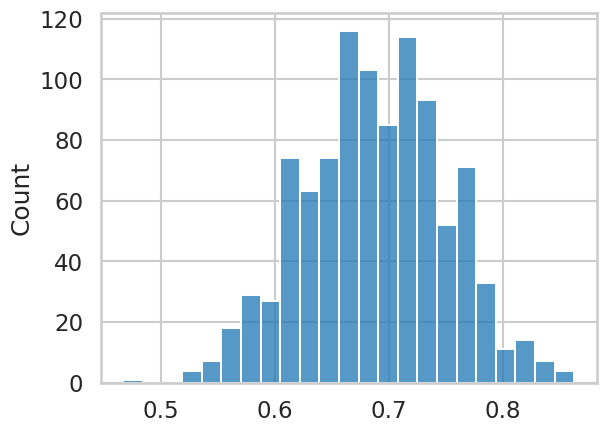

In [24]:
sns.histplot(scores)

A representative sample near the mean of the scores is randomstate = 4 with a score of 0.692

In [66]:
data_dev['group'].value_counts()

Healthy       132
AD_MCI         43
PD_MCI_LBD     32
PD             31
Name: group, dtype: int64

In [62]:
def mrmr_feature_selection(X_train, y_train,X_val,y_val,K,model):
    feature_performance = []
    for k in K:
        reduced_features = mrmr.mrmr_classif(X_train,y_train,K=k)
        X_train_reduced = X_train[reduced_features]
        X_val_reduced = X_val[reduced_features]
        model.fit(X_train_reduced,y_train)
        feature_performance.append([k,sklearn.metrics.balanced_accuracy_score(y_val,model.predict(X_val_reduced)),reduced_features])
    #feature_performance.append([len(X_train.columns),model.score(X_val_reduced|,y_val),X_train.columns])
    return feature_performance

In [34]:
randomstate

4

In [67]:
folded_performances = []
i=0
while i < 5:
    # split the dev data into train and val
    data_train, df_val_empty, data_val, randstate =split_cats_by_tolerance(data_dev,0.01,dev_test_split=0.15,train_val_split=0.01, randstate=np.random.randint(1,2**31))
    train_eq, randomstate = over_under(data_train,data_val)
    X_traineq = train_eq.drop(columns='group')
    y_traineq = train_eq['group']
    X_val = data_val.drop(columns='group')
    y_val = data_val['group']
    feature_performances = mrmr_feature_selection(X_traineq,y_traineq,X_val,y_val,range(1,21),sklearn.linear_model.RidgeClassifier())
    folded_performances.append(feature_performances)
    i += 1

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.85it/s]


KeyError: 'PD_MCI_LBD'

In [68]:
folded_performances

[[[1, 0.3125, ['1433G']],
  [2, 0.30833333333333335, ['1433G', 'HBA']],
  [3, 0.37083333333333335, ['1433G', 'HBA', 'PPT1']],
  [4, 0.41250000000000003, ['1433G', 'HBA', 'PPT1', 'CADH5']],
  [5, 0.4625, ['1433G', 'HBA', 'PPT1', 'CADH5', 'MATN3']],
  [6, 0.5, ['1433G', 'HBA', 'PPT1', 'CADH5', 'MATN3', 'TWSG1']],
  [7, 0.4625, ['1433G', 'HBA', 'PPT1', 'CADH5', 'MATN3', 'TWSG1', '1433Z']],
  [8,
   0.42500000000000004,
   ['1433G', 'HBA', 'PPT1', 'CADH5', 'MATN3', 'TWSG1', '1433Z', 'NPY']],
  [9,
   0.35,
   ['1433G',
    'HBA',
    'PPT1',
    'CADH5',
    'MATN3',
    'TWSG1',
    '1433Z',
    'NPY',
    'HDHD2']],
  [10,
   0.275,
   ['1433G',
    'HBA',
    'PPT1',
    'CADH5',
    'MATN3',
    'TWSG1',
    '1433Z',
    'NPY',
    'HDHD2',
    'NAGAB']],
  [11,
   0.2625,
   ['1433G',
    'HBA',
    'PPT1',
    'CADH5',
    'MATN3',
    'TWSG1',
    '1433Z',
    'NPY',
    'HDHD2',
    'NAGAB',
    'PGAM4']],
  [12,
   0.2625,
   ['1433G',
    'HBA',
    'PPT1',
    'CADH5',
    'MATN

In [79]:
folded_df = pd.DataFrame(data=folded_performances)

In [85]:
folded_df[20

0    [20, 0.325, [1433G, HBA, PPT1, CADH5, MATN3, T...
1    [20, 0.47916666666666663, [1433Z, CO7, GNPTG, ...
Name: 19, dtype: object

100%|███████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 13.35it/s]


In [46]:
feature_performances

[[1, 0.35833333333333334, ['TAU']],
 [2, 0.4083333333333333, ['TAU', 'LTBP2']],
 [3, 0.4208333333333334, ['TAU', 'LTBP2', 'GALT6']],
 [4, 0.43333333333333335, ['TAU', 'LTBP2', 'GALT6', 'SRCRL']],
 [5, 0.3666666666666667, ['TAU', 'LTBP2', 'GALT6', 'SRCRL', 'HAVR2']],
 [6, 0.41666666666666663, ['TAU', 'LTBP2', 'GALT6', 'SRCRL', 'HAVR2', 'ENOA']],
 [7,
  0.44166666666666665,
  ['TAU', 'LTBP2', 'GALT6', 'SRCRL', 'HAVR2', 'ENOA', 'NPTX2']],
 [8,
  0.4041666666666667,
  ['TAU', 'LTBP2', 'GALT6', 'SRCRL', 'HAVR2', 'ENOA', 'NPTX2', 'VASN']],
 [9,
  0.4291666666666667,
  ['TAU',
   'LTBP2',
   'GALT6',
   'SRCRL',
   'HAVR2',
   'ENOA',
   'NPTX2',
   'VASN',
   '1433G']],
 [10,
  0.42083333333333334,
  ['TAU',
   'LTBP2',
   'GALT6',
   'SRCRL',
   'HAVR2',
   'ENOA',
   'NPTX2',
   'VASN',
   '1433G',
   'CAH2']],
 [11,
  0.5458333333333333,
  ['TAU',
   'LTBP2',
   'GALT6',
   'SRCRL',
   'HAVR2',
   'ENOA',
   'NPTX2',
   'VASN',
   '1433G',
   'CAH2',
   'C1QC']],
 [12,
  0.445833333333333

In [47]:
num_features, score, features = zip(*feature_performances)

<AxesSubplot: >

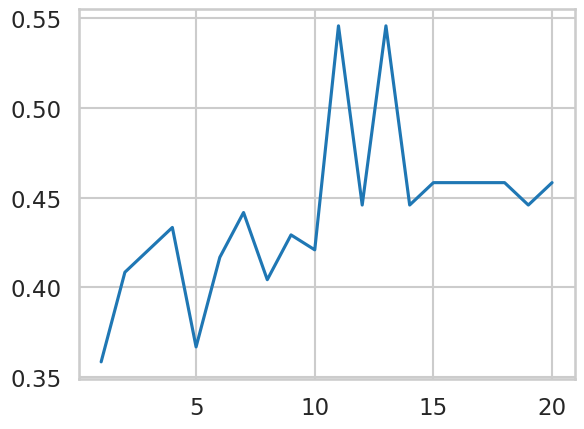

In [48]:
sns.lineplot(x=num_features,y=score)

In [113]:
a, b, c = zip(*feature_performance)

<AxesSubplot: >

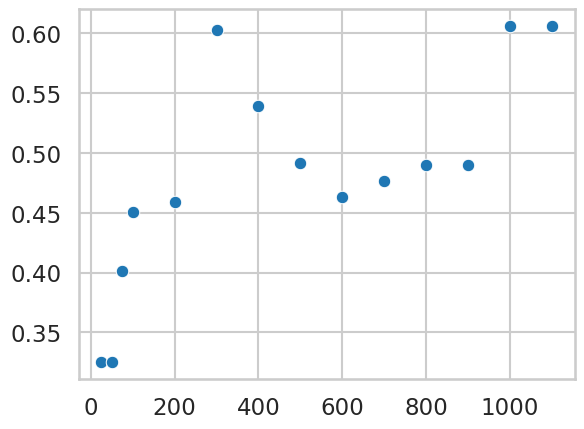

In [116]:
sns.scatterplot(x=a,y=b)

In [97]:
feature_performance

[[50,
  0.5833333333333334,
  ['GDIA',
   'APOC1',
   'ICAM1',
   'PPT1',
   'AK1C1',
   'PGK1',
   'SMOC1',
   'CAH2',
   '1433G',
   'MMP2',
   'TAU',
   'LRP1B',
   'ENOA',
   'CADH5',
   'PGK2',
   'NPTX2',
   'TIMP2',
   '1433Z',
   'TWSG1',
   'HDHD2',
   'MIA',
   'VWF',
   'PROF2',
   '1433B',
   'CADH8',
   'SERC',
   'SCUB1',
   'LDHA',
   'CO7',
   'PAL4A',
   'B2MG',
   'FREM2',
   '1433T',
   'GSHR',
   'LDH6A',
   'GDIB',
   'KPYM',
   'CO6A2',
   'C1QC',
   'ALDOA',
   'SRCRL',
   'AGRB1',
   'CATS',
   'PZP',
   'GUAD',
   'MA1C1',
   '1433F',
   'NDKB',
   'CEMIP',
   'LDH6B']]]

In [ ]:
def train_cat_equalizer(df_train,df_val,randomstate=1,categories=['Healthy','AD_MCI','PD','PD_MCI_LBD']):
    def cat_prequalizer(df_train,randomstate=1,categories=['Healthy','AD_MCI','PD','PD_MCI_LBD']):
        """
        Randomly selects rows among each category such that each category has an equal number of rows.
        Ensures the truncated training frame has the same columns with NaN so if NaN columns are dropped, the truncated training frame has the same features as the val and test frames
        """

        # Determine the value counts of each category in in the training datal
        d = dict(df_train['group'].value_counts())
        min_cat = min(d, key=d.get)
        min_count = min(d.values())
        #print('Minimum category,',min_cat,', has',min_count,'rows... returning training data with',min_count,'rows for each category')

        dataframes = []
        for i in range(0,len(categories)):
            dataframes.append(df_train[df_train['group'] == categories[i]].sample(n=min_count,random_state=randomstate))
            
        df_train_eq = pd.concat(dataframes)
        df_train_eq = pd.DataFrame(df_train_eq)

        return df_train_eq
    
    def randomstate_sampler(df_train,df_val):
    # Sample random states to pick a frequent value. This has a similar motivation to bagging:
    # Bagging samples subsets of the data many times to build an ensemble model,
    # this method samples subsets of the data and picks a "typical" subset
        randomsamplestates = {}
        for i in range(1,100):
            df_train_eq = cat_prequalizer(df_train,randomstate=i)
            X_train = df_train_eq.drop(columns=['group','assay_ID'])
            y_train = df_train_eq['group']
            X_val = df_val.drop(columns=['group','assay_ID'])
            y_val = df_val['group']
            model = sklearn.linear_model.RidgeClassifier()
            model.fit(X_train,y_train)
            randomsamplestates[i] = model.score(X_val,y_val)
        value, count = Counter(randomsamplestates.values()).most_common(1)[0]
        print('Most frequent score:',value,'Count:',count,'/100')
        print('randomstate:',list(randomsamplestates.values()).index(value)+1)
        rep_randomstate = list(randomsamplestates.values()).index(value)+1
        sns.histplot(randomsamplestates.values())
        
        return rep_randomstate, value, count
        
    df_train_eq = cat_prequalizer(df_train)
    rep_randomstate, value, count = randomstate_sampler(df_train,df_val)
    df_train_eq = cat_prequalizer(df_train,randomstate=rep_randomstate)
    
    return df_train_eq, value, count, rep_randomstate

In [89]:
list(range(0,100,2))

[0,
 2,
 4,
 6,
 8,
 10,
 12,
 14,
 16,
 18,
 20,
 22,
 24,
 26,
 28,
 30,
 32,
 34,
 36,
 38,
 40,
 42,
 44,
 46,
 48,
 50,
 52,
 54,
 56,
 58,
 60,
 62,
 64,
 66,
 68,
 70,
 72,
 74,
 76,
 78,
 80,
 82,
 84,
 86,
 88,
 90,
 92,
 94,
 96,
 98]